# PyTorch로 neural network를 훈련하기: MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

---

## 1.1 data set loading

`DataLoader` 모듈을 사용해서 간단히 load할 수 있다.

> batch size는 보편적으로 사용하는 32로 지정했다. tradeoff가 있기 때문에 적절한 값을 사용해야 한다.

> 또한 **normalize**(정규화)를 적용하여 정규분포를 따르도록 수정했다.

In [2]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
    batch_size=500, shuffle=False)

---

## 1.2 model architecture 정의

![model architecture](images/CNN_architecture.png)

- input image: (28X28X1) gray scale

- 첫 번째 convolutional layer: (26X26X16)

  - input channel 1, output channel 16, kernel size 3, stride 1

  - activation function: ReLU

- 두 번째 convolutional layer: (24X24X32)

  - input channel 16, output channel 32, kernel size 3, stride 1

  - activation function: ReLU

> 사실 kernel size가 5X5인 convolutional layer와 공간 커버리지 관점에서는 동일하다. 하지만 이렇게 여러 layer로 구성된 깊이가 더 깊은 network를 사용하면 더 복잡한 feature를 학습할 수 있다. 또한 parameter 수도 줄일 수 있다.

다음은 model architecture를 구현한 code이다.

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)   # 12 X 12 X 32 = 4608
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

---

## 1.3 training routine

실제 traning routine, 즉 실제 backpropagation 단계를 정의한다. `torch.optim` 모듈을 이용해 간결한 code로 구성한다.

다음은 train data set에 사용할 routine이다. 이 과정을 한 번 수행하는 것을 1 **epoch**(세대)라고 한다.

> 다시 말해 여기서 1 epoch는 data set 전체를 읽는 시간을 뜻한다.

In [4]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)            # 예측값
        loss = F.nll_loss(pred_prob, y) # nll: negative likelihood loss
        loss.backward()                 # gradients 계산
        optim.step()                    # weight update
        if b_i % 10 == 0:               # batch 10개마다 training loss를 출력한다.
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

---

## 1.4 test routine

다음은 test data set에서 사용할 routine이다.

> train routine과의 차이는 계산한 loss를 사용해서 update를 수행하지 않는다는 점이다. 대신 loss는 전체 test error 총합을 위해 사용한다. 

In [5]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

---

## 1.5 optimizer와 device 정의

optimizer로 AdaDelta를 사용하고 learning rate를 0.5로 설정했다. 장치는 CPU를 사용한다.

> data가 sparsity를 가질 경우 AdaDelta가 유용하다.

In [6]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

---

## 1.6 training

In [7]:
# 2epoch만 출력해 본다.
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924132
epoch: 1 [640/60000 (1%)]	 training loss: 1.313337
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678459
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477065
epoch: 1 [2240/60000 (4%)]	 training loss: 0.527093
epoch: 1 [2560/60000 (4%)]	 training loss: 0.469393
epoch: 1 [2880/60000 (5%)]	 training loss: 0.239183
epoch: 1 [3200/60000 (5%)]	 training loss: 0.523874
epoch: 1 [3520/60000 (6%)]	 training loss: 0.269437
epoch: 1 [3840/60000 (6%)]	 training loss: 0.464022
epoch: 1 [4160/60000 (7%)]	 training loss: 0.413103
epoch: 1 [4480/60000 (7%)]	 training loss: 0.326608
epoch: 1 [4800/60000 (8%)]	 training loss: 0.493001
epoch: 1 [5120/60000 (9%)]	 training loss: 0.154175
epoch: 1 [5440/60000 (9%)]	 training loss: 0.356458
epoch: 1 [5760/60000 (10%)]	 training loss: 0.092037
epoch: 1 [6080/60

---

## 1.7 trained model로 inference하기

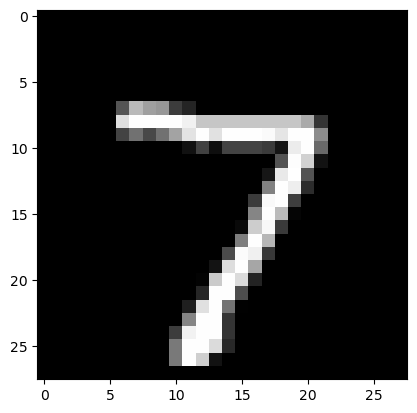

In [8]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [9]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 7
Ground truth is : 7
